# Braintriage challenge example

# Import packages
Here we import important packages. Add any packages you need.

In [97]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data
import os
import SimpleITK as sitk
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import math as math
import csv
import pandas as pd
from tqdm.notebook import tqdm
import pdb

## reload scripts before executing them
%load_ext autoreload
%autoreload 2

## importing python files from another directory
from dataset.create_slices import generate_slice_data
from dataset.patient_dataframes import get_patient_train_val_dataframes
from dataset.patient_dataset import PatientDataset
from dataset.slice_dataframes import get_slice_train_val_dataframes
from dataset.slice_dataset import SliceDataset

from visualisation.slice_plotter import plot_slices

from models.feature_vector_model import FeatureVectorModel

from train.train import Trainer

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Intro
In this notebook I'm going to copy whatever steps are in LSTM_Freek but instead of using the functions defined in the notebook I'm going to use the sames defined in the files. Which are the same...

# Create dataset
We only have to extract the slices once so I decide to extract all slices. The resolution is 512x512x32 so we can assume each patient has 32 slices.

## output will be 65 gb....


In [72]:
in_dir = '../../data/full'
out_dir = '../../data_sliced'
## generate slice data now accepts two parameters namely:
## IN_DIR location of the raw ata
## OUT_DIR preferred output location of the slices
generate_slice_data(in_dir,out_dir)

In [76]:
DATA_DIR = out_dir

In [77]:
label_df = pd.read_csv(os.path.join(DATA_DIR,"labels_slices.csv"), names = ["patient_nr", "slice_nr", "class"])
label_df["class"] = label_df["class"].astype("int8")
patient_list = np.unique(label_df["patient_nr"])
print(label_df.head(), f"Dataframe shape: {label_df.shape}", sep="\n")
print(f"\nNumber of unique patient numbers: {len(np.unique(label_df['patient_nr']))}")
print(f"Number of unique slice numbers:   {len(np.unique(label_df['slice_nr']))}")
print(f"Number of unique class values:    {len(np.unique(label_df['class']))}")

   patient_nr  slice_nr  class
0         607         0      1
1         607         1      1
2         607         2      1
3         607         3      1
4         607         4      1
Dataframe shape: (3840, 3)

Number of unique patient numbers: 100
Number of unique slice numbers:   32
Number of unique class values:    2


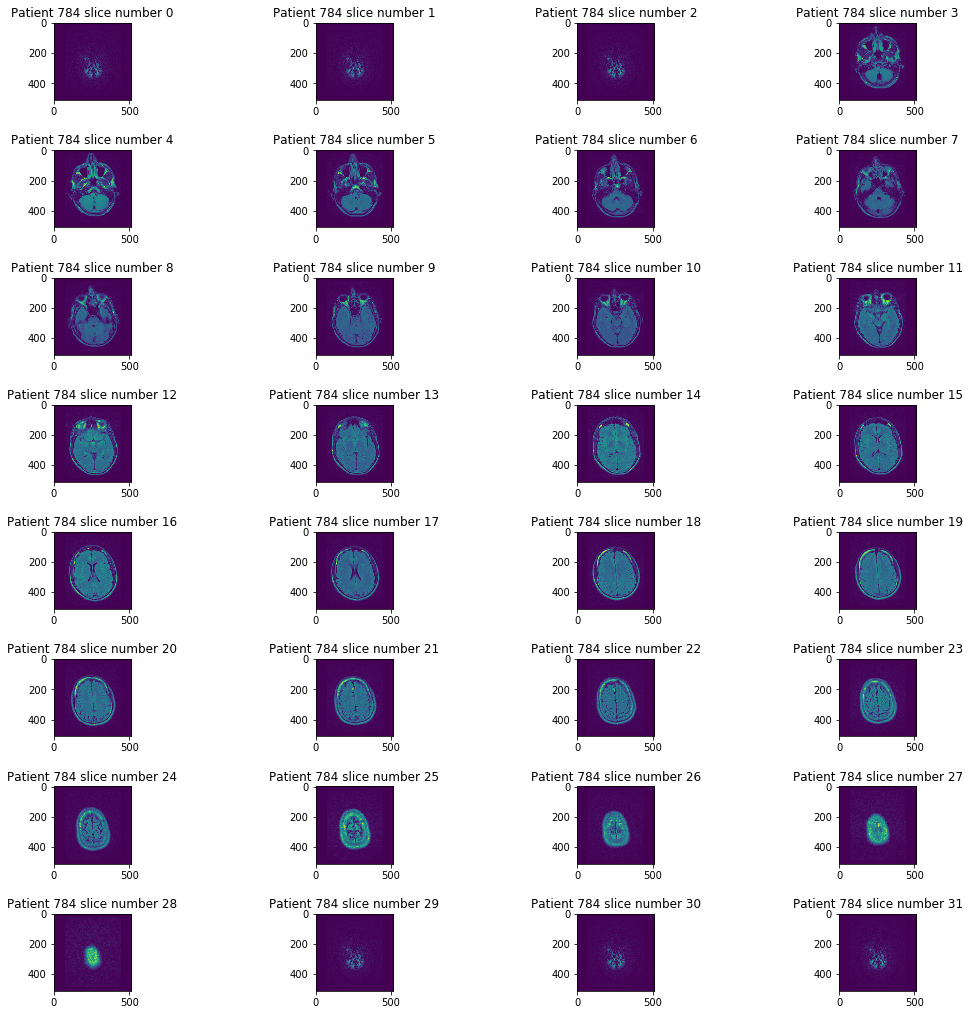

In [80]:
plot_slices(784, (0,31), DATA_DIR)

We create a dataset class that is compatible with the 'data_loader' from PyTorch. This allows us to feed our images to the network efficiently during training and validation. We read the labels for the different patients from a CSV file and convert this into a dictionary. Based on these labels we split the data in a training and validation set (you can choose a different ratio).

## Global train/validation parameters

In [81]:
### Parameters ###
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'  # Train on GPU or CPU
TARGET_SLICES = 14                                       # The slices we will train on for each patient
N_FEATURES = 128                                         # The length of feature vectors that the CNN outputs/LSTM will use
TRAIN_PERCENTAGE = 0.9                                   # Percentage of data that will be used for training

## CNN network

### CNN-specific parameters

In [87]:
### Parameters ###
epochs = 1
batch_size = 2
n_features = 128

model_dir = './models'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

### Create model ###
fc_net = FeatureVectorModel(n_features=n_features)

### Loss and optimizer ###
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(fc_net.parameters(), lr=0.0001)

### Create data generator (redefine for each network) ###
train_df, val_df = get_slice_train_val_dataframes(label_df, train_percentage = TRAIN_PERCENTAGE)

training_set = SliceDataset(train_df, TARGET_SLICES, DATA_DIR)
validation_set = SliceDataset(val_df, TARGET_SLICES, DATA_DIR)

training_iterator = data.DataLoader(training_set, batch_size=batch_size, shuffle = True)
validation_iterator = data.DataLoader(validation_set, batch_size=batch_size, shuffle = False)

### Train and Validate CNN
First we instantiate the Trainer Object 

In [98]:
trainer = Trainer(model=fc_net, criterion=criterion, optimizer=optimizer, 
                   train_loader=training_iterator, val_loader=validation_iterator, n_epochs=epochs, model_dir = model_dir)
trainer.train_and_validate()

Running FCNet


epoch:   1 / 001, training loss: 4433.4714, validation loss: 572.6212, training accuracy: 0.519, validation accuracy: 0.625.



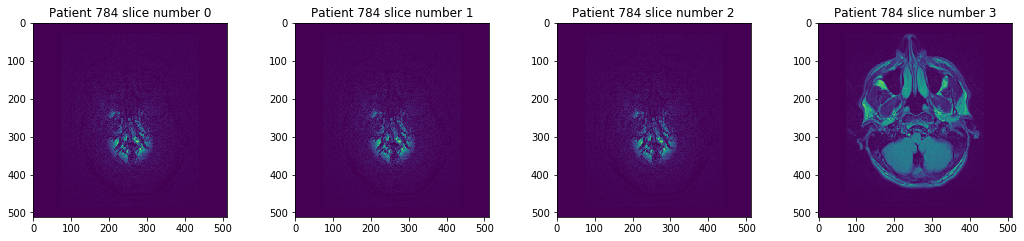

In [5]:
data_dir = '../../data_test'

plot_slices(784,(0,3))

## Fully connected model for Feature extraction


In [6]:
class FeatureVectorModel(nn.Module):
    def __init__(self, n_features):
        super(FeatureVectorModel, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_1 = nn.Linear(512*512*3, 256)
        self.feature_linear = nn.Linear(256, n_features)
        self.classification_linear = nn.Linear(n_features, 1)
        # For saving model and loss values
        self.name = "FCNet" 
        
    def forward(self, x):
        h = self.linear_1(self.flatten(x))
        h = self.feature_linear(h)
        h = self.classification_linear(h)
        # We don't need Softmax when using BCEWithLogitsLoss
        return h
        

## LSTM Model

In [7]:
class LSTM(nn.Module):
    def __init__(self, n_features, n_hidden, n_layers=1):
        super(LSTM, self).__init__()
        self.lstm = nn.LSTM(input_size=n_features, hidden_size=n_hidden, 
                            num_layers=n_layers, batch_first=True)
        self.classification_linear = nn.Linear(n_hidden,1)
        # For saving model and loss values
        self.name = "LSTMNet" 
        
    def forward(self, x):
        lstm_output, (_, _) = self.lstm(x)
        output = self.classification_linear(lstm_output[:,-1])
        return output

## Combined model

In [19]:
class CombinedNet(nn.Module):
    def __init__(self, fc_net, lstm_net, do_freeze_fc_net=False):
        super(CombinedNet, self).__init__()
        # Remove classification layer from FC network
        self.fc_net = torch.nn.Sequential(*(list(fc_net.children())[:-1]))
        self.lstm_net = lstm_net
        # For saving model and loss values
        self.name = "CombinedNet" 
    
    def forward(self, x):
        '''
        THIS CODE WILL BE RELEVANT FOR WHEN WE HAVE MULTIPLE SLICES IN THE DATA

        # Loop over all slices and compute feature vectors with FC net
        feature_vectors = []
        for slice_ in x:
            feature_vector = self.fc_net(slice_)
            feature_vectors.append(feature_vector)

        # Convert to Tensor and compute predictions with LSTM net
        feature_tensor = torch.Tensor(feature_vectors)
        prediction = self.lstm_net(feature_tensor)
        '''
        
        ## x is dict, where keys are patient numbers and values are lists of images
        ## normally a batch would consist of timeseries data
        ## in this case a batch consists of patients and each patient consists of a timeseries...
        ## so we convert to batch of timeseries..
        
        ## first layer of featurextractnetwork expects a batch... so we consider patient as a batch.
        if type(x) == dict:
            feature_vectors = []
            for patient, list_of_images in x.items():
                patient_images = []
                patient_feature_vector = []
                for image in list_of_images:
                    patient_images.append(image)

                patient_feature_vector = self.fc_net(torch.stack(patient_images[:1])) ## [:2] to make sure same size some patients have 3 slices instead of 2 ...

                feature_vectors.append(patient_feature_vector[0])
            feature_vector = torch.stack(feature_vectors)

        else:
            feature_vector = self.fc_net(x)

        feature_vector = torch.unsqueeze(feature_vector, 1)
        prediction = self.lstm_net(feature_vector)
        return prediction

    def set_learning_fc_net(self, do_learning):
        for param in self.fc_net.parameters():
                param.requires_grad = do_learning

# Initialize model
Here we set the different training and model parameters. The model is initialized and a loss function and optimizer are choosen. Finally a training and validation iterator is created.

In [9]:
### Parameters ###
device = 1
epochs = 1
batch_size = 5
n_features=128

model_dir = './models'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

### Create model ###
# model = Model(in_channels,outsize) #.cuda() # if device < 0 else Model(1,outsize).to_gpu(device)
model = FeatureVectorModel(n_features=n_features)
### Loss and optimizer ###
criterion = nn.BCEWithLogitsLoss()#nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.000001)

### Create data generator ###

training_iterator = data.DataLoader(training_set, batch_size=batch_size, shuffle = True)
validation_iterator = data.DataLoader(validation_set, batch_size=batch_size, shuffle = False)

# Training and validation
In the next cell the model is trained and validated. The loss is printed and the model is saved after every epoch.

In [18]:
def train(model, loss, optimizer, train_loader, val_loader, batch_size, n_epochs=1):
    print(f'Running {model.name}')

    ### Training and validation ###
    loss_history = {'training': [], 'validation': []}
    acc_history = {'training': [], 'validation': []}

    for j in tqdm(range(n_epochs), desc="#epochs"):
        loss_history['training'].append(0)
        acc_history['training'].append(0)

        for i, (patients,slices,images, targets) in tqdm(enumerate(train_loader), total=len(training_set)//(batch_size+1), desc="#train_batches", leave=False):

            model.train()
            optimizer.zero_grad()
            
#             if model.name == "CombinedNet":
#                 predictions = model()
#             else:
            predictions = model(images)
            if type(targets) == dict:
                targets = torch.stack(list(targets.values()))
            loss = criterion(predictions, targets)
            loss.backward()

            optimizer.step()
            
            #Accuracy
            accuracy_predictions = (F.sigmoid(predictions)>0.5).float()

            correct = (accuracy_predictions == targets).float().sum()/accuracy_predictions.shape[0]

            loss_history['training'][-1] += float(loss.data)
            acc_history['training'][-1] += float(correct)

        loss_history['training'][-1] /= i + 1
        acc_history['training'][-1] /= i + 1

        loss_history['validation'].append(0)
        acc_history['validation'].append(0)

        for i, (patients,slices,images, targets) in tqdm(enumerate(val_loader), total=len(validation_set)//(batch_size+1), desc="#test_batches", leave=False):

            model.eval()

            predictions = model(images)
            if type(targets) == dict:
                targets = torch.stack(list(targets.values()))
            loss = criterion(predictions, targets)
            
            #Accuracy
            accuracy_predictions = (F.sigmoid(predictions)>0.5).float()
            correct = (accuracy_predictions == targets).float().sum()/accuracy_predictions.shape[0]
        
            loss_history['validation'][-1] += float(loss.data)
            acc_history['validation'][-1] += float(correct)

        loss_history['validation'][-1] /= i + 1
        acc_history['validation'][-1] /= i + 1

        print('epoch: {:3d} / {:03d}, training loss: {:.4f}, validation loss: {:.4f}, training accuracy: {:.3f}, validation accuracy: {:.3f}.'.format(j + 1, epochs, loss_history['training'][-1], loss_history['validation'][-1], acc_history['training'][-1], acc_history['validation'][-1]))
        np.savez('{:s}/{:s}_loss_history_{:03d}.npz'.format(model_dir, model.name, j), loss_history)
        torch.save(model.state_dict(), '{:s}/{:s}_{:03d}.npz'.format(model_dir, model.name, j))

## FC NET

In [11]:
### Parameters ###
epochs = 1
batch_size = 2
n_features = 128

model_dir = './models'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

### Create model ###
fc_net = FeatureVectorModel(n_features=n_features)

### Loss and optimizer ###
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(fc_net.parameters(), lr=0.0001)

### Create data generator (redefine for each network) ###
training_iterator = data.DataLoader(training_set, batch_size=batch_size, shuffle = True)
validation_iterator = data.DataLoader(validation_set, batch_size=batch_size, shuffle = False)

In [12]:
train(model=fc_net, loss=criterion, optimizer=optimizer, 
      train_loader=training_iterator, val_loader=validation_iterator, 
      batch_size=batch_size, n_epochs=epochs)

Running FCNet


/home/chb3k/anaconda3/envs/py37ismi/lib/python3.7/site-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


epoch:   1 / 001, training loss: 7987.4760, validation loss: 8265.1217, training accuracy: 0.542, validation accuracy: 0.500.



## LSTM

In [20]:
### Parameters ###
epochs = 1
batch_size = 32
n_features = 128
n_hidden = 64

model_dir = './models'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

### Create model ###
lstm_net = LSTM(n_features=n_features, n_hidden=n_hidden, n_layers=1)
combined_net = CombinedNet(fc_net=fc_net, lstm_net=lstm_net)
# Turn off learning for FC_net
combined_net.set_learning_fc_net(False)

### Loss and optimizer ###
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(combined_net.parameters(), lr=0.0001)

### Create data generator (redefine for each network) ###
training_iterator = data.DataLoader(training_set, batch_size=batch_size, shuffle = True)
validation_iterator = data.DataLoader(validation_set, batch_size=batch_size, shuffle = False)

In [14]:
train(model=combined_net, loss=criterion, optimizer=optimizer, 
      train_loader=training_iterator, val_loader=validation_iterator, 
      batch_size=batch_size, n_epochs=epochs)

Running CombinedNet


> <ipython-input-8-b06bfdea3980>(55)forward()
-> prediction = self.lstm_net(feature_vector)
(Pdb) cont


> <ipython-input-8-b06bfdea3980>(55)forward()
-> prediction = self.lstm_net(feature_vector)
(Pdb) cont
epoch:   1 / 001, training loss: 0.6968, validation loss: 0.6882, training accuracy: 0.375, validation accuracy: 0.667.



In [15]:
## The Combined Model LSTM part needs multiple slices from patient x 
## maybe we can achieve this functionality with the collate function
## https://pytorch.org/docs/1.1.0/_modules/torch/utils/data/dataloader.html
## https://discuss.pytorch.org/t/questions-about-dataloader-and-dataset/806/11
## https://discuss.pytorch.org/t/how-to-create-a-dataloader-with-variable-size-input/8278


def collate_fn(batch):
    ## filter based on patients

    patients = {}
    slices = {}
    images = {}
    targets = {}
    for b in batch: ## patient,slice_number, X, y
        if b[0] in patients:
            patients[b[0]] = b[0] ## just overwrite patient 
            slices[b[0]].append(b[1])
            images[b[0]].append(b[2])
            targets[b[0]] = b[3] #.append(b[3])
        else:
            patients[b[0]] = b[0] ## just overwrite patient 
            slices[b[0]] = [b[1]]
            images[b[0]] = [b[2]]
            targets[b[0]] = b[3]##[b[3]]
#     pdb.set_trace()

    ## combination of 
    ## https://stackoverflow.com/questions/6618515/sorting-list-based-on-values-from-another-list
    ## https://stackoverflow.com/questions/30690134/list-comprehension-inside-dictionary-comprehension-scope
    images = {k: [x for _, x in sorted(zip(slices[k],v))] for  k,v in images.items()}
    
    
    
    ## targets should be per patient and not per slice
    #targets =  {k: [x for _, x in sorted(zip(slices[k],v))] for  k,v in targets.items()}
    
    
    
    
    ##adopt targets, should be targets per patient...
    return patients,slices,images,targets
        
        


## CombinedNet


In [25]:
### Parameters ###
epochs = 1
batch_size = 32

# Turn learning for fc_net back on
combined_net.set_learning_fc_net(True)

### Loss and optimizer ###
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(combined_net.parameters(), lr=0.0001)

### Create data generator (redefine for each network) ###
training_iterator = data.DataLoader(training_set, batch_size=batch_size, shuffle = True,collate_fn = collate_fn)
validation_iterator = data.DataLoader(validation_set, batch_size=batch_size, shuffle = False,collate_fn = collate_fn)

In [26]:
train(model=combined_net, loss=criterion, optimizer=optimizer, 
      train_loader=training_iterator, val_loader=validation_iterator, 
      batch_size=batch_size, n_epochs=epochs)

Running CombinedNet


<class 'list'>
24


<class 'list'>
6
epoch:   1 / 001, training loss: 0.7180, validation loss: 0.6868, training accuracy: 0.500, validation accuracy: 0.600.



# Testing
Here we show some example code that you can use to run your model on the test data set once this is provided and create a .csv submission file that you can upload to grand challenge.

# Select slices for test set
Here we do the same as above to select slices from the test set.

In [ ]:
in_dir = 'path/to/test_in_dir'
out_dir = 'path/to/test_out_dir'


if not os.path.exists(out_dir):
    os.makedirs(out_dir)
            
for klass in os.listdir(in_dir):

    for patient in os.listdir(os.path.join(in_dir, klass)):

        ## Check if patient has not been processed yet
        out_path = os.path.join(out_dir, patient+'.pt')
        if not os.path.exists(out_path):

            ## Paths to the image files
            t1_path = os.path.join(in_dir,klass,patient,'T1.mha')
            t2_path = os.path.join(in_dir,klass,patient,'T2.mha')
            t2_flair_path = os.path.join(in_dir,klass,patient,'T2-FLAIR.mha')

            ## Load all images
            t1_image = sitk.ReadImage(t1_path)
            t2_image = sitk.ReadImage(t2_path)
            t2_flair_image = sitk.ReadImage(t2_flair_path)

            ## Check if the number of slices is equal in all series
            if t1_image.GetSize()[-1] == t2_image.GetSize()[-1] == t2_flair_image.GetSize()[-1]:
                
                with open(out_dir+'/labels_slices_z_test.csv', 'a') as csvfile:
                    w = csv.writer(csvfile, delimiter=',')

                    if klass == 'normal':
                        w.writerow([patient, 0])
                    elif klass == 'abnormal':
                        w.writerow([patient, 1])
                
                ## Determine center slice of images
                z = int(t1_image.GetSize()[-1]/2)

                ## Convert the images to numpy arrays
                t1_array = sitk.GetArrayFromImage(t1_image)
                t2_array = sitk.GetArrayFromImage(t2_image)
                t2_flair_array = sitk.GetArrayFromImage(t2_flair_image)

                ## Extract the center slices from the images
                t1_slice = t1_array[z,:,:]
                t2_slice = t2_array[z,:,:]
                t2_flair_slice = t2_flair_array[z,:,:]

                ## Create one data array
                comb_data = np.zeros((3,512,512))
                comb_data[0,:,:] = t1_slice
                comb_data[1,:,:] = t2_slice
                comb_data[2,:,:] = t2_flair_slice
                
                ## Save as torch tensor for quick loading during training
                torch.save(torch.from_numpy(comb_data.astype('float32')),out_dir+'/'+patient+'.pt')

                
                print("Slices saved for:", patient)

                del t1_array, t2_array, t2_flair_array

            else:
                print("Number of slices not equal for:", patient)
                del t1_image, t2_image, t2_flair_image
        else:
            continue

We create a test dataset from these slices.

In [ ]:
### Specify test data directory ###    
test_dir = '/path/to/test_out_dir'

### Load labels and convert to dict ###
labels_test = {}

with open(test_dir+'/labels_slices_z_test.csv', 'r') as csvfile:
    reader = csv.reader(csvfile)
    for rows in reader:
        labels_test[rows[0]] = float(rows[1])
           
data_sets['test'] = np.asarray(list(labels_test.keys()))

test_set = Dataset(data_sets['test'], labels_test, test_dir)


# Run trained model on the test set.
Run the model with the best validation loss on the test set to obtain a 'submission' csv file. You can upload this file to grand challenge to see how well you perform and add your score to the leaderboard.

In [ ]:
test_iterator = data.DataLoader(test_set, batch_size=1, shuffle = False)

j = 4
model = Model(in_channels,outsize).cuda() # if device < 0 else Model(1,outsize).to_gpu(device)
checkpoint = torch.load('{:s}/model_{:03d}.npz'.format(model_dir, j))

model.load_state_dict(checkpoint)
model.eval()
m =nn.Sigmoid()

with open(test_dir+'/submission.csv', 'a') as csvfile:
    w = csv.writer(csvfile, delimiter=',')
    w.writerow(['case','probability','class'])
    for i, batch in enumerate(test_iterator):
        images, targets = batch[0].cuda() , batch[1].cuda()
        y = model(images)
        prob = m(y)
        output = prob>0.5
        patient = data_sets['test'][i]
        w.writerow([patient, float(prob), int(output)])